In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import os

from test_simplify import test_basic, load_net, batch_predict
from test_batch import collect_predict,adaptive_chain_smoother,load_predict,interpolation_collected,choose_chain_collected,test_arrow

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
def plot_trace(x,y, alpha=1.0):
    n = x.shape[0]
    plt.plot(x[:n//3],y[:n//3],'-o',color='r', alpha=alpha)
    plt.plot(x[n//3:n//3*2],y[n//3:n//3*2],'-o',color='g', alpha=alpha)
    plt.plot(x[n//3*2:],y[n//3*2:],'-o',color='b', alpha=alpha)


In [4]:
smoother = lambda arr: adaptive_chain_smoother(arr, F=6)

In [5]:
loaded_raw = load_predict('hiv00200_cache')

In [6]:
loaded = copy.deepcopy(loaded_raw)
collected = collect_predict(loaded, chain_smoother=smoother, jump_tol=60, pixel_threshold = 70, verbose=True)
sorted([len(chain) for chain in collected['chain_list']], reverse=True)

12 chain detected


[12951, 12951, 4530, 1592, 1479, 1260, 1198, 1165, 1106, 755, 353, 4]

In [7]:
collected = interpolation_collected(collected)

In [8]:
collected = choose_chain_collected(collected, 100)

In [9]:
collected.keys()

dict_keys(['predict_cache', 'predict_cache_map', 'id2key', 'key2id', 'chain_list'])

In [10]:
collected['predict_cache'][0][0]

{'score': tensor(0.9552, device='cpu'),
 'label_name': 'boat',
 'pt': array([ 84.943985, 192.39137 , 498.8001  , 252.94171 ], dtype=float32),
 'matched': True,
 'head': True,
 'frame': 0,
 'pt_smoothed': array([ 76.91148, 193.50763, 485.60208, 253.46487], dtype=float32),
 'pt_smoothed_next': array([ 76.267746, 193.57457 , 484.81952 , 253.46864 ], dtype=float32),
 'pt_next': array([ 84.777374, 192.494   , 496.02768 , 253.14656 ], dtype=float32),
 'delta': array([-0.71313477,  0.03535461], dtype=float32),
 'delta_smoothed': array([-0.79102784,  0.03880844], dtype=float32),
 'chain': <test_batch.DummyPointer at 0x26d906f65f8>}

In [11]:
ordered_chain_list = sorted([chain for chain in collected['chain_list']], reverse=True, key=len)
[len(chain) for chain in ordered_chain_list]

[12951, 12951, 4530, 1594, 1479, 1260, 1198, 1180, 1106, 755, 353]

In [12]:
chain = ordered_chain_list[3]
len(chain)

1594

In [13]:
chain[0],chain[len(chain)//2],chain[-2],chain[-1]

({'score': tensor(0.1067, device='cpu'),
  'label_name': 'boat',
  'pt': array([ -3.4025407, 270.64236  ,  45.240917 , 319.0262   ], dtype=float32),
  'matched': True,
  'head': True,
  'frame': 5664,
  'pt_smoothed': array([ -4.060414, 268.14795 ,  72.75403 , 317.83813 ], dtype=float32),
  'pt_smoothed_next': array([ -4.0565777, 268.12848  ,  72.97208  , 317.83264  ], dtype=float32),
  'pt_next': array([ -3.6430264, 268.6426   ,  47.640568 , 318.90552  ], dtype=float32),
  'delta': array([ 0.22188187, -0.02493286], dtype=float32),
  'delta_smoothed': array([ 0.23159552, -0.02306366], dtype=float32),
  'chain': <test_batch.DummyPointer at 0x26d90d4be10>},
 {'score': tensor(0.8965, device='cpu'),
  'label_name': 'boat',
  'pt': array([278.8824 , 236.98619, 939.6149 , 314.3556 ], dtype=float32),
  'matched': True,
  'frame': 6461,
  'pt_smoothed': array([276.08228, 238.02173, 942.24567, 315.3707 ], dtype=float32),
  'pt_smoothed_next': array([277.26785, 238.01625, 943.50745, 315.36523], 

In [14]:
chain[0]['delta_smoothed'],chain[len(chain)//2]['delta_smoothed'],chain[-2]['delta_smoothed']

(array([ 0.23159552, -0.02306366], dtype=float32),
 array([ 1.2070129 , -0.00400162], dtype=float32),
 array([0.2428833 , 0.00037231], dtype=float32))

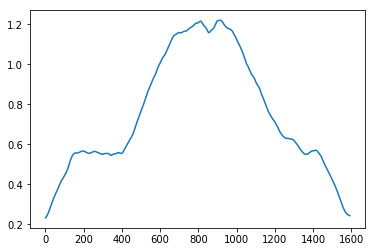

In [15]:
plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])

可见只用中点估计的缺陷十分明显，所以可以考虑用四点最大变化的那个值来计算速度。不过这个事情只对

In [16]:
chain = ordered_chain_list[0]
len(chain)

12951

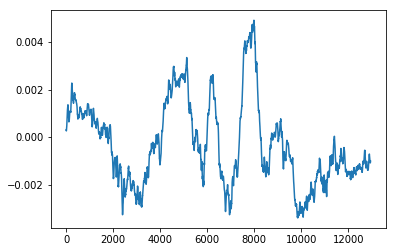

In [17]:
plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])

In [18]:
chain = ordered_chain_list[1]
len(chain)

12951

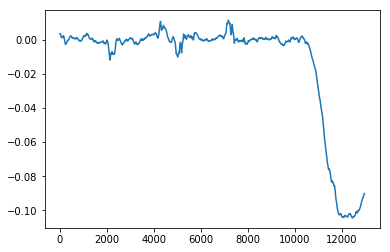

In [19]:
plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])

In [20]:
chain = ordered_chain_list[2]
len(chain)

4530

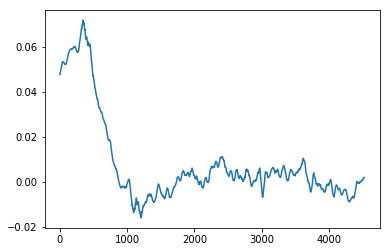

In [21]:
plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])

In [22]:
chain = ordered_chain_list[4]
len(chain)

1479

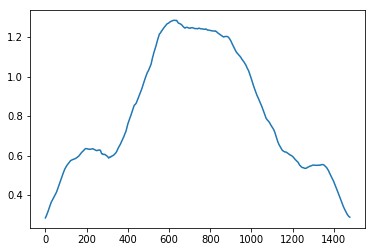

In [23]:
plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])

12951


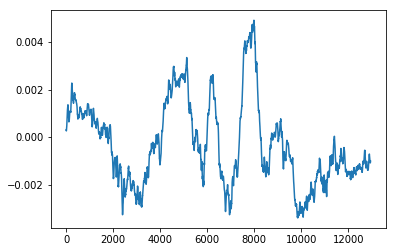

12951


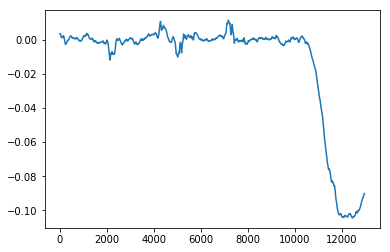

4530


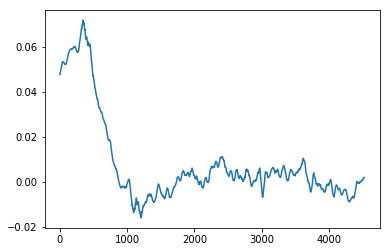

1594


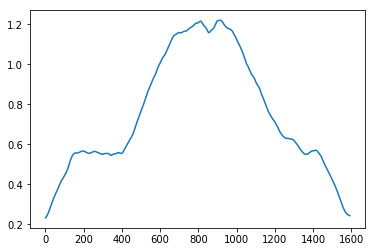

1479


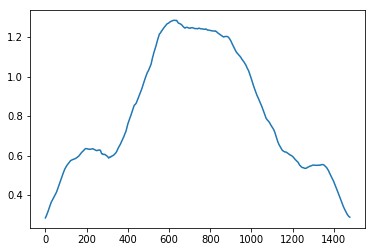

1260


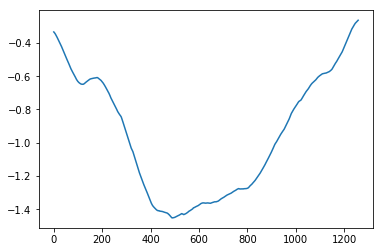

1198


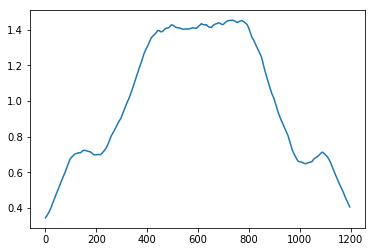

1180


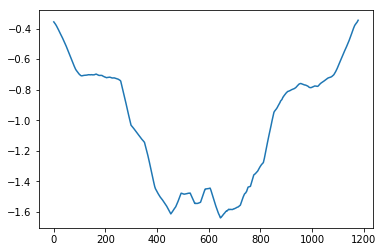

1106


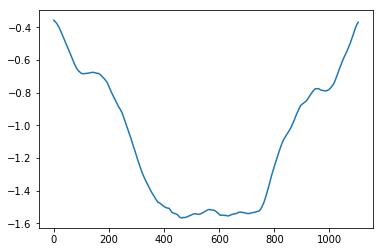

755


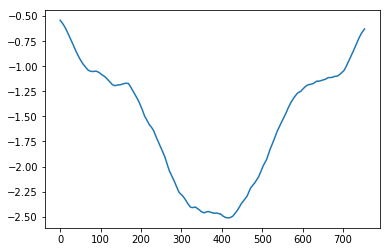

353


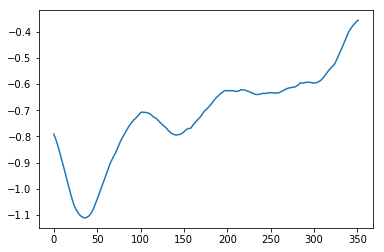

In [24]:
for chain in ordered_chain_list:
    print(len(chain))
    plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])
    plt.show()

In [25]:
def chain_desc(chain, moving_threshold=0.02):
    '''
    Sideeffect:
        It will assign last but one delta_smoothed value to last element in a chain
    '''
    if 'delta_smoothed' not in chain[-1]:
        chain[-1]['delta_smoothed'] = chain[-2]['delta_smoothed']
    
    res_list = []
    for box in chain + [None]: # None is the guard to activate following logic
        #print(len(res_list),box['delta_smoothed'][0],abs(box['delta_smoothed'][0]) < moving_threshold)
        if box is None or abs(box['delta_smoothed'][0]) < moving_threshold:
            #print('enter',  box['delta_smoothed'][0], abs(box['delta_smoothed'][0]) < moving_threshold)
            if len(res_list) != 0:
                
                arr = np.array([box['delta_smoothed'][0] for box in res_list])
                speed = arr[np.argmax(np.abs(arr))]
                for _box in res_list:
                    _box['right_speed'] = speed
                res_list = []
        #print('middle', box['delta_smoothed'][0], abs(box['delta_smoothed'][0]) < moving_threshold)
        if box is not None:
            if abs(box['delta_smoothed'][0]) < moving_threshold:
                #print('zeroed', box['delta_smoothed'][0],abs(box['delta_smoothed'][0]) < moving_threshold)
                box['right_speed'] = 0.0
                box['static'] = True
            else:
                #print('tracked', box['delta_smoothed'][0],abs(box['delta_smoothed'][0]) < moving_threshold)
                res_list.append(box)
        
def chain_list_desc(chain_list, moving_threshold=0.02):
    for chain in chain_list:
        chain_desc(chain)
    
    for idx,chain in enumerate(chain_list):
        for box in chain:
            box['chain_list_idx'] = idx
    

In [29]:
chain_list_desc(ordered_chain_list)
#ordered_chain_list[0][:10]

In [30]:
len(collected['chain_list'][1]),collected['chain_list'][1][:5]

(12951,
 [{'score': tensor(0.9169, device='cpu'),
   'label_name': 'boat',
   'pt': array([1184.7594 ,   91.13778, 1276.0452 ,  145.60579], dtype=float32),
   'matched': True,
   'head': True,
   'frame': 0,
   'pt_smoothed': array([1183.4637 ,   90.62363, 1276.8704 ,  145.5424 ], dtype=float32),
   'pt_smoothed_next': array([1183.4619 ,   90.6211 , 1276.8726 ,  145.54349], dtype=float32),
   'pt_next': array([1184.3722 ,   91.44277, 1275.5519 ,  144.8631 ], dtype=float32),
   'delta': array([ 0.00024414, -0.00072479], dtype=float32),
   'delta_smoothed': array([ 0.00029907, -0.00067215], dtype=float32),
   'chain': <test_batch.DummyPointer at 0x26d8b5cef28>,
   'right_speed': 0.0,
   'static': True,
   'chain_list_idx': 0},
  {'score': tensor(0.9296, device='cpu'),
   'label_name': 'boat',
   'pt': array([1184.3722 ,   91.44277, 1275.5519 ,  144.8631 ], dtype=float32),
   'matched': True,
   'frame': 1,
   'pt_smoothed': array([1183.4619 ,   90.6211 , 1276.8726 ,  145.54349], dtype=fl

12951


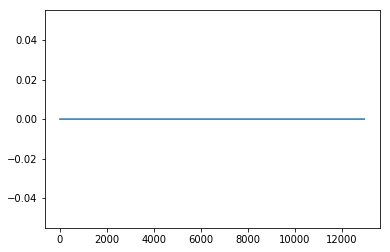

12951


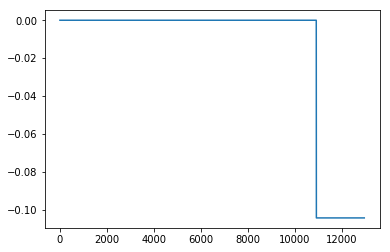

4530


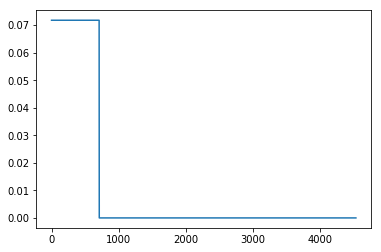

1594


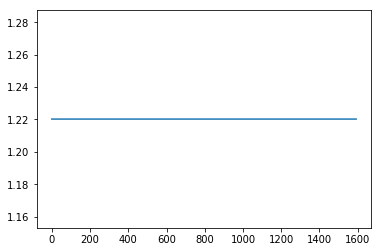

1479


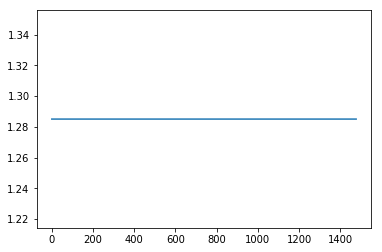

1260


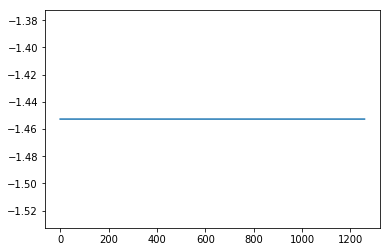

1198


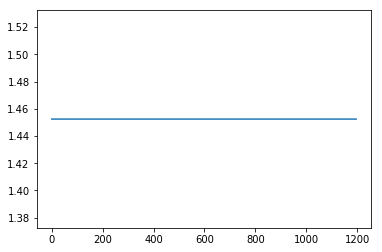

1180


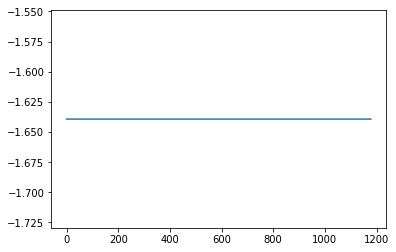

1106


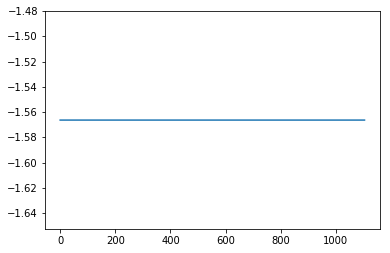

755


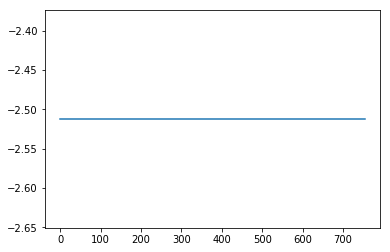

353


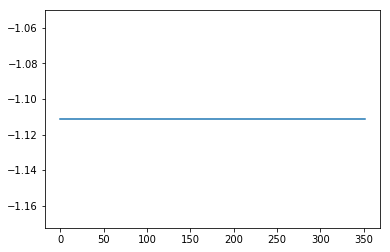

In [31]:
for chain in ordered_chain_list:
    print(len(chain))
    plt.plot([box['right_speed'] if box['right_speed'] is not None else 0 for box in chain[:-1]])
    plt.show()

12951


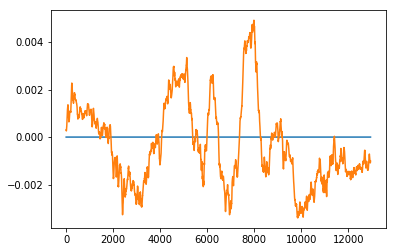

12951


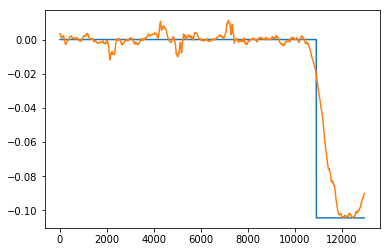

4530


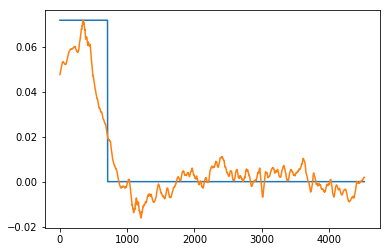

1594


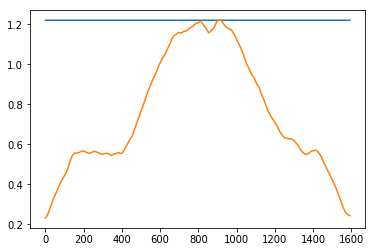

1479


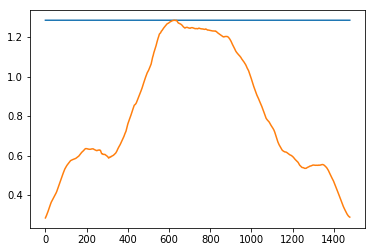

1260


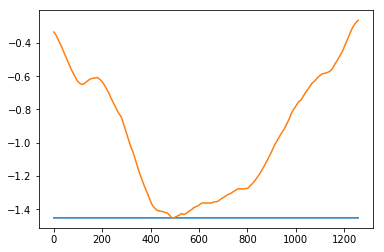

1198


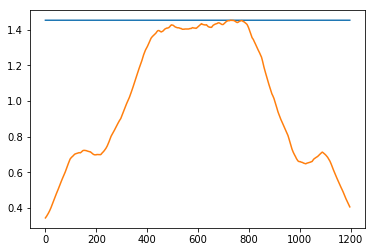

1180


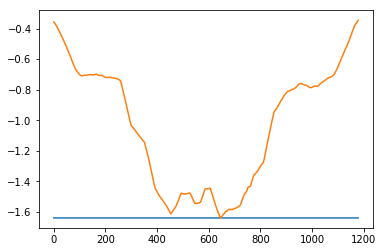

1106


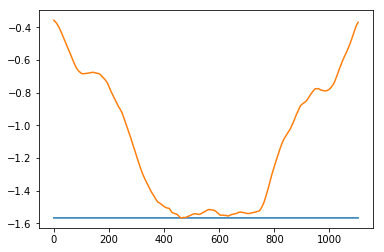

755


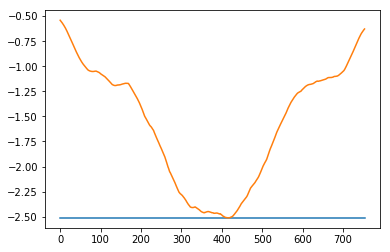

353


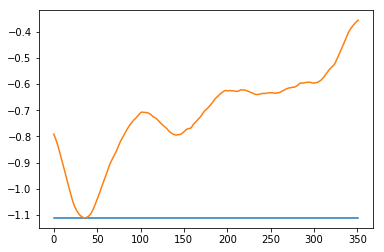

In [32]:
for chain in ordered_chain_list:
    print(len(chain))
    plt.plot([box['right_speed'] if box['right_speed'] is not None else 0 for box in chain[:-1]])
    plt.plot([box['delta_smoothed'][0] for box in chain[:-1]])
    plt.show()

In [33]:
img_root = r'E:\ship_detect_demo\hiv00200_frames'

In [34]:
predict_cache_map = collected['predict_cache_map']

In [35]:
cache_name = 'thumb00025.cache'
#cache_name = 'thumb00005.cache'

In [129]:
cvt=False
delta_smoothed = smoother
resize_factor = None

name, ext = os.path.splitext(cache_name)
img_path = '{}/{}.jpg'.format(img_root, name)

img_processed = test_arrow(cache_name, img_path, predict_cache_map, cvt=cvt, 
       delta_smoothed = delta_smoothed, resize_factor=resize_factor)


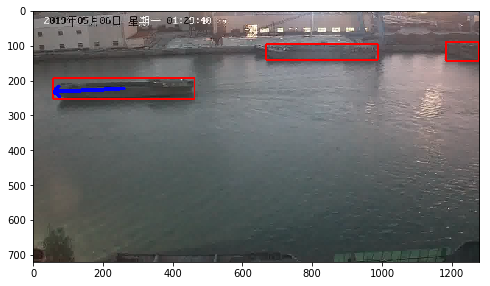

In [130]:
plt.figure(figsize=(8,6))
plt.imshow(img_processed)

In [131]:
collected['predict_cache_map']['thumb00025.cache']

[{'score': tensor(0.8278, device='cpu'),
  'label_name': 'boat',
  'pt': array([ 55.479813, 195.72314 , 457.96146 , 254.09619 ], dtype=float32),
  'matched': True,
  'frame': 24,
  'pt_smoothed': array([ 57.598507, 194.987   , 462.34674 , 254.07079 ], dtype=float32),
  'pt_smoothed_next': array([ 56.58054, 195.06274, 461.10654, 254.13255], dtype=float32),
  'pt_next': array([ 53.549786, 195.6546  , 457.232   , 254.02232 ], dtype=float32),
  'delta': array([-1.1290894,  0.0687561], dtype=float32),
  'delta_smoothed': array([-199.78221 ,    9.331021], dtype=float32),
  'chain': <test_batch.DummyPointer at 0x26d906f6cc0>,
  'right_speed': -1.1112972,
  'chain_list_idx': 10},
 {'score': tensor(0.9428, device='cpu'),
  'label_name': 'boat',
  'pt': array([1181.8212 ,   91.65694, 1279.3601 ,  144.58679], dtype=float32),
  'matched': True,
  'frame': 24,
  'pt_smoothed': array([1183.4244 ,   90.57002, 1276.9243 ,  145.56635], dtype=float32),
  'pt_smoothed_next': array([1183.4235  ,   90.5674

In [132]:
from PIL import ImageFont, ImageDraw, Image
fontpath = "SIMYOU.TTF"
font = ImageFont.truetype(fontpath, 25) # 20 is font size

def draw_chinese(img_processed, text, pos, fill = (255, 0, 0)):
    img_pil = Image.fromarray(img_processed)
    draw = ImageDraw.Draw(img_pil)
    draw.text(pos, text, font = font, fill = fill)
    return np.array(img_pil)

In [133]:
sorted_frame_box_list = sorted(collected['predict_cache_map']['thumb00025.cache'], key=lambda box:box['chain_list_idx'])

row_height = 40
column_start = int(img_processed.shape[1]/4)
total = len(sorted_frame_box_list)

for idx,box in enumerate(sorted_frame_box_list):
    lefttop = box['pt_smoothed'][:2]
    org = (int(lefttop[0]-25), int(lefttop[1]))
    text = str(idx+1)
    cv2.putText(img_processed, text, org, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)
    
    metre_per_pixel = 100 / img_processed.shape[1]
    metre_per_frame = box['right_speed'] * metre_per_pixel
    meter_per_second = metre_per_frame * 24
    km_per_hour = meter_per_second * 3600 / 1000
    
    center = (int(box['pt_smoothed'][::2].mean()),int(box['pt_smoothed'][1::2].mean()))
    width = int(box['pt_smoothed'][2] - box['pt_smoothed'][0])
    height = int(box['pt_smoothed'][3] - box['pt_smoothed'][1])
    if box['right_speed'] == 0.0:
        direction = '无'
    elif box['right_speed'] > 0.0:
        direction = '右'
    else:
        direction = '左'
    desc = '船只{}: 中心点坐标:({},{}) 长:({}) 宽:({}), 方向:({}) 速度:({}KM/H)'.format(idx+1, center[0], center[1],
                width, height, direction, int(round(abs(km_per_hour))))
    
    org_desc = (column_start, img_processed.shape[0] - row_height*(total-idx))
    #cv2.putText(img_processed, desc, org_desc, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)
    img_processed = draw_chinese(img_processed, desc, org_desc, fill = (255, 23, 0))

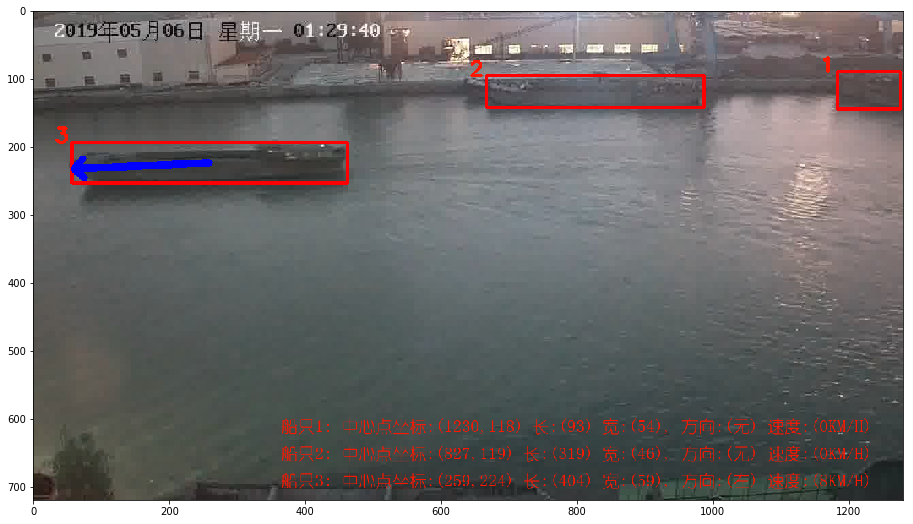

In [135]:
plt.figure(figsize=(16,9))
plt.imshow(img_processed)

`cv2.putText`不兹磁中文还行，虽然也不明白为什么要用中文。

In [84]:
fontpath = "SIMYOU.TTF"

In [85]:
font = ImageFont.truetype(fontpath, 32)
img_pil = Image.fromarray(img_processed)
draw = ImageDraw.Draw(img_pil)
draw.text((50, 80),  "端午节就要到了。。。", font = font, fill = (255, 0, 0))

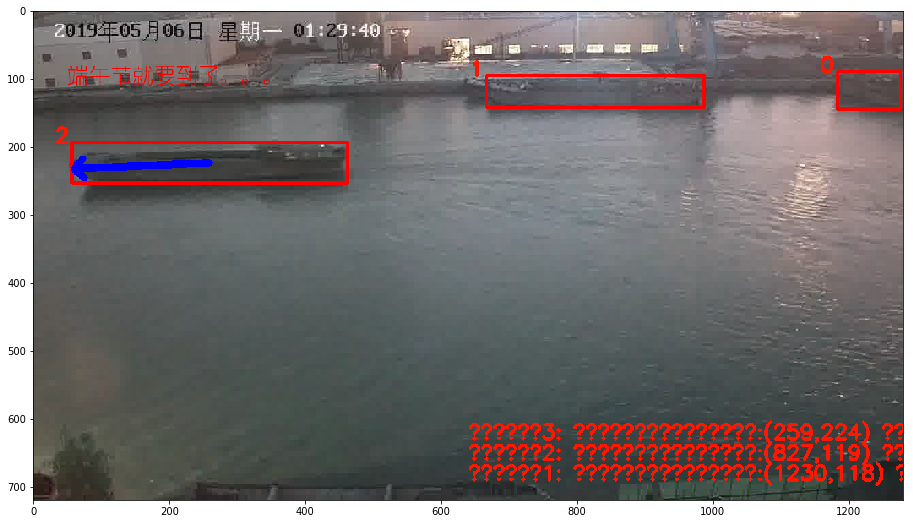

In [88]:
plt.figure(figsize=(16,9))
plt.imshow(img_pil)

In [137]:
def draw_legend(img_processed, cache_name, predict_cache_map):
    
    
    sorted_frame_box_list = sorted(predict_cache_map[cache_name], key=lambda box:box['chain_list_idx'])

    row_height = 40
    column_start = int(img_processed.shape[1]/4)
    total = len(sorted_frame_box_list)

    for idx,box in enumerate(sorted_frame_box_list):
        lefttop = box['pt_smoothed'][:2]
        org = (int(lefttop[0]-25), int(lefttop[1]))
        text = str(idx+1)
        cv2.putText(img_processed, text, org, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)

        metre_per_pixel = 100 / img_processed.shape[1]
        metre_per_frame = box['right_speed'] * metre_per_pixel
        meter_per_second = metre_per_frame * 24
        km_per_hour = meter_per_second * 3600 / 1000

        center = (int(box['pt_smoothed'][::2].mean()),int(box['pt_smoothed'][1::2].mean()))
        width = int(box['pt_smoothed'][2] - box['pt_smoothed'][0])
        height = int(box['pt_smoothed'][3] - box['pt_smoothed'][1])
        if box['right_speed'] == 0.0:
            direction = '无'
        elif box['right_speed'] > 0.0:
            direction = '右'
        else:
            direction = '左'
        desc = '船只{}: 中心点坐标:({},{}) 长:({}) 宽:({}), 方向:({}) 速度:({}KM/H)'.format(idx+1, center[0], center[1],
                    width, height, direction, int(round(abs(km_per_hour))))

        org_desc = (column_start, img_processed.shape[0] - row_height*(total-idx))
        #cv2.putText(img_processed, desc, org_desc, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)
        img_processed = draw_chinese(img_processed, desc, org_desc, fill = (255, 23, 0))
        
    return img_processed

In [138]:
cache_name = 'thumb01025.cache'


In [139]:
cvt=False
delta_smoothed = smoother
resize_factor = None

name, ext = os.path.splitext(cache_name)
img_path = '{}/{}.jpg'.format(img_root, name)

img_processed = test_arrow(cache_name, img_path, predict_cache_map, cvt=cvt, 
       delta_smoothed = delta_smoothed, resize_factor=resize_factor)


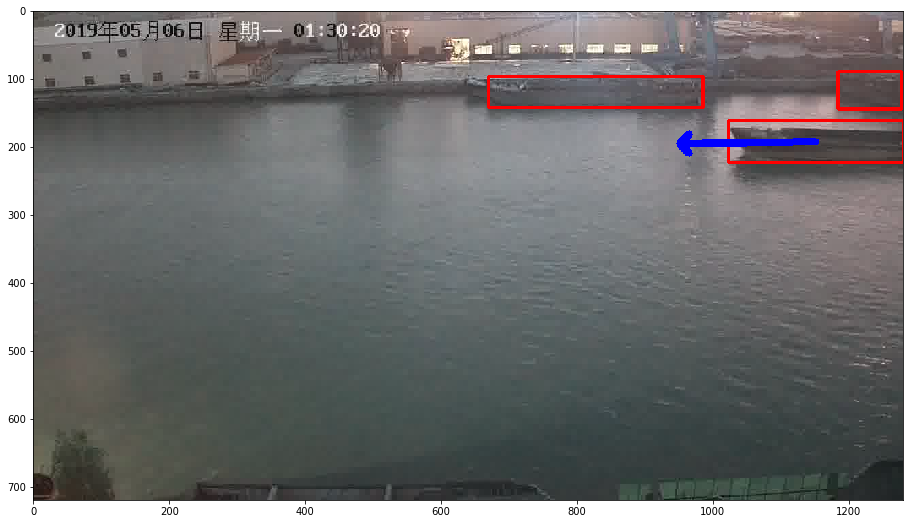

In [141]:
plt.figure(figsize=(16,9))
plt.imshow(img_processed)

In [142]:
img_processed = draw_legend(img_processed, cache_name, predict_cache_map)

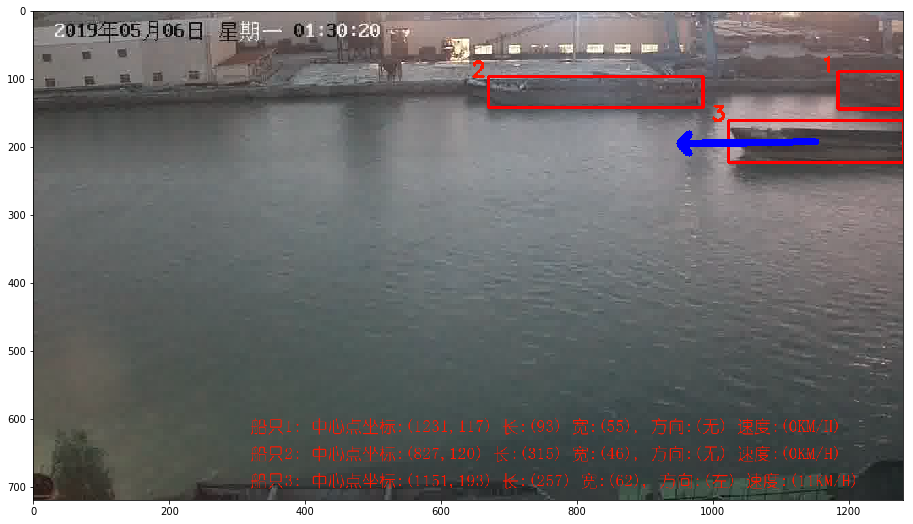

In [143]:
plt.figure(figsize=(16,9))
plt.imshow(img_processed)